In [1]:
import yfinance as yf
import gurobipy as gp
from gurobipy import GRB
from math import sqrt
import pandas as pd
"""## Collecting Data"""
stocks = ['TATAMOTORS.NS', 'TATAPOWER.NS', 'RELIANCE.NS', 'SUZLON.NS', 'MMTC.NS', 
          'ADANIPOWER.NS', 'ADANIPORTS.NS', 'IOC.NS', 'YESBANK.NS', 'ZOMATO.NS', 
          'AWL.NS', 'TITAN.NS', 'ASIANPAINT.NS', 'BANDHANBNK.NS', 'IDBI.NS', 
          'JWL.NS', 'NHPC.NS', 'VEDL.NS', 'WIPRO.NS', 'TECHM.NS', 'MCX.NS', 
          'PNB.NS', 'JIOFIN.NS', 'GSPL.NS', 'AXISBANK.NS', 'IRFC.NS', 'RVNL.NS', 
          'BHEL.NS', 'IREDA.NS', 'GLAXO.NS']

# Download historical data for the stocks
data = yf.download(stocks, period='1y')['Adj Close'].dropna()

# Calculate daily returns
returns = data.pct_change().dropna()

[*********************100%%**********************]  30 of 30 completed


In [2]:
import numpy as np

rf_daily = 0.07  # Daily risk-free rate

# Example beta values (replace with actual values)
# Assuming all betas are 1 for illustration
betas = np.ones(len(stocks))

# Calculate CAPM-adjusted expected returns (mu)
market_risk_premium = 0.05  # Example market risk premium
mu = rf_daily + betas * market_risk_premium

# Calculate CAPM-adjusted delta
closes = np.transpose(np.array(data))  # matrix of daily closing prices
absdiff = np.diff(closes)  # change in closing price each day
reldiff = np.divide(absdiff, closes[:, :-1])  # relative change in daily closing price

# CAPM-adjusted delta calculation
delta = np.mean(reldiff, axis=1) + mu

# Calculate CAPM-adjusted sigma (covariance matrix)
sigma = np.cov(reldiff)

# Calculate CAPM-adjusted standard deviation (std)
std= np.std(reldiff, axis=1)

In [28]:
"""## Minimize risk by solving QP model"""
# Create an empty model
m = gp.Model('portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
# Verify model formulation
m.write('portfolio_selection_optimization.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0xd085a07a
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 8e-01]
Presolve time: 0.00s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.579

In [29]:
"""## Display minimum risk portfolio using Pandas"""
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])


,Minimum Risk Portfolio
TATAMOTORS.NS,6.926678e-09
TATAPOWER.NS,1.456863e-08
RELIANCE.NS,2.619644e-01
SUZLON.NS,1.634981e-02
MMTC.NS,1.126902e-01
ADANIPOWER.NS,2.492567e-08
ADANIPORTS.NS,7.091990e-09
IOC.NS,1.901476e-02
YESBANK.NS,8.689425e-02
ZOMATO.NS,1.070981e-08


In [5]:
"""## Compute the efficient frontier"""
# Create an expression representing the expected return for the portfolio
portfolio_return = delta @ x
target = m.addConstr(portfolio_return == minrisk_return, 'target')
# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(delta.min(), delta.max(), 25):
    target.rhs = r
    m.optimize()
    frontier = np.append(frontier, [[sqrt(m.ObjVal)],[r]], axis=1)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 2 rows, 30 columns and 60 nonzeros
Model fingerprint: 0xee85fc56
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+00]
Presolve time: 0.01s
Presolved: 2 rows, 30 columns, 60 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.650e+02
 Factor NZ  : 4.960e+02
 Factor Ops : 1.042e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.569

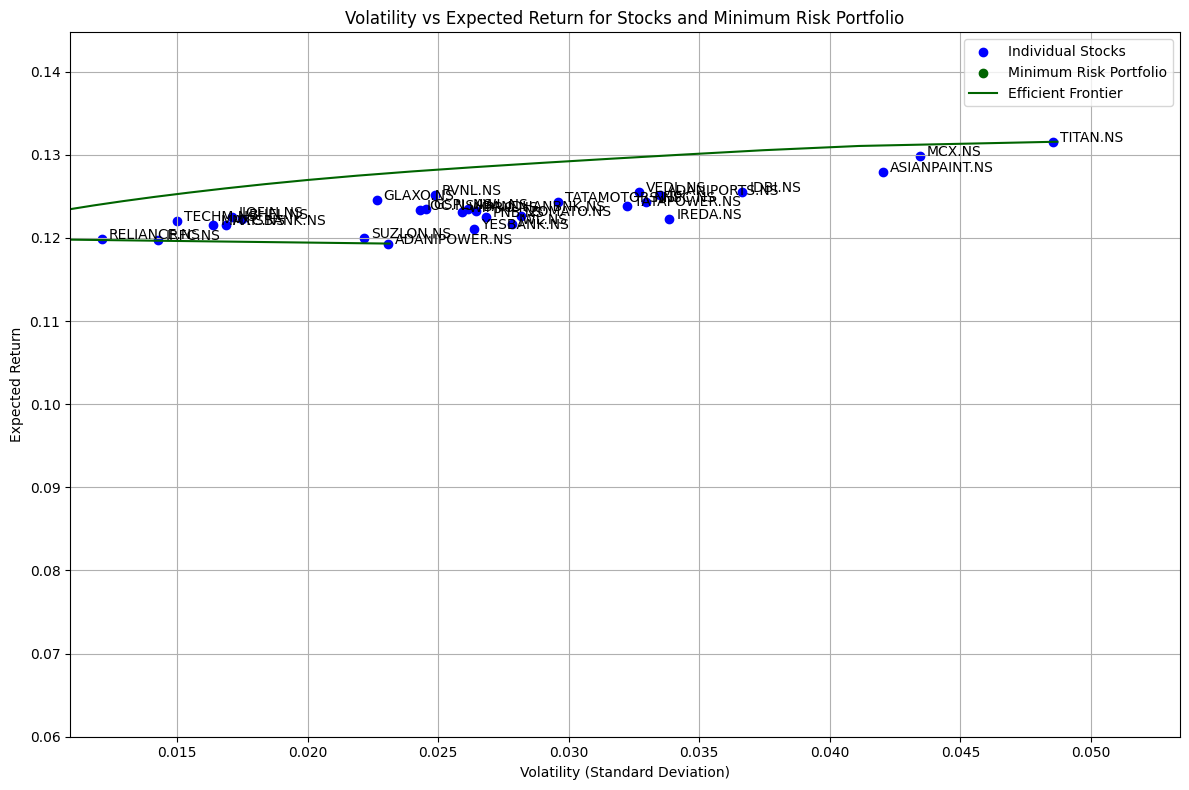

In [6]:
import matplotlib.pyplot as plt

# Adjust figure size and create subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Plot volatility versus expected return for individual stocks
ax.scatter(x=std, y=delta, color='blue', label='Individual Stocks')
for i, stock in enumerate(stocks):
    ax.annotate(stock, (std[i], delta[i]), xytext=(5, 0), textcoords='offset points')

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=minrisk_volatility, y=minrisk_return, color='darkgreen', label='Minimum Risk Portfolio')
ax.annotate('Minimum\nRisk\nPortfolio', (minrisk_volatility, minrisk_return), 
            xytext=(-50, 10), textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.5),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5', color='red'))

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Efficient Frontier', color='darkgreen')

# Set axis limits with padding
ax.set_xlim([min(std)*0.9, max(std)*1.1])
ax.set_ylim([0.06, max(delta)*1.1])  # Ensure y-axis starts from 0.06

# Set labels and title
ax.set_xlabel('Volatility (Standard Deviation)')
ax.set_ylabel('Expected Return')
ax.set_title('Volatility vs Expected Return for Stocks and Minimum Risk Portfolio')

# Display legend, grid, and show plot
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()



In [26]:
import pandas as pd
portfolio = max_sharpe_ratio(sigma, delta)
# Original list of 30 stocks
stocks = ['TATAMOTORS.NS', 'TATAPOWER.NS', 'RELIANCE.NS', 'SUZLON.NS', 'MMTC.NS',
          'ADANIPOWER.NS', 'ADANIPORTS.NS', 'IOC.NS', 'YESBANK.NS', 'ZOMATO.NS',
          'AWL.NS', 'TITAN.NS', 'ASIANPAINT.NS', 'BANDHANBNK.NS', 'IDBI.NS',
          'JWL.NS', 'NHPC.NS', 'VEDL.NS', 'WIPRO.NS', 'TECHM.NS', 'MCX.NS',
          'PNB.NS', 'JIOFIN.NS', 'GSPL.NS', 'AXISBANK.NS', 'IRFC.NS', 'RVNL.NS',
          'BHEL.NS', 'IREDA.NS', 'GLAXO.NS']

# Example portfolio weights (replace with actual values)
portfolio_weights = portfolio.x

# Create DataFrame
df_portfolio = pd.DataFrame({
    'Stocks': stocks,
    'Weights': portfolio_weights,
    'Sharpe Ratio': [portfolio.sharpe_ratio/10] * len(stocks),
    'Expected Return': [portfolio.ret] * len(stocks),
    'Volatility': [portfolio.risk] * len(stocks)
})

# Append row for overall portfolio metrics
df_portfolio.loc['Portfolio Metrics'] = ['', '', portfolio.sharpe_ratio/10, portfolio.ret, portfolio.risk]

# Display DataFrame
print("Portfolio Summary:")
print(df_portfolio)


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-16
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0x345e9297
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e-01, 1e-01]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 5e-03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Resi

In [17]:
"""Sharpe Ratio Optimization"""
# Create an empty model
m = gp.Model('sharp_ratio_portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ (sigma- (1.02**(1/252)-1)/100)/std @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
# Verify model formulation
m.write('portfolio_selection_optimization_sharpe.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 1 rows, 30 columns and 30 nonzeros
Model fingerprint: 0xf971754d
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-04, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.02s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.300

,Minimum Risk Portfolio
TATAMOTORS.NS,2.735562e-11
TATAPOWER.NS,9.708688e-10
RELIANCE.NS,2.160165e-01
SUZLON.NS,3.961660e-02
MMTC.NS,1.487595e-01
ADANIPOWER.NS,1.321506e-10
ADANIPORTS.NS,2.878579e-11
IOC.NS,5.351883e-02
YESBANK.NS,1.617981e-01
ZOMATO.NS,3.384468e-11


In [14]:
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])

,Minimum Risk Portfolio
TATAMOTORS.NS,6.562559e-09
TATAPOWER.NS,1.163420e-08
RELIANCE.NS,1.300000e-01
SUZLON.NS,3.014226e-02
MMTC.NS,1.299999e-01
ADANIPOWER.NS,1.873834e-07
ADANIPORTS.NS,4.254599e-09
IOC.NS,4.965968e-02
YESBANK.NS,1.166829e-01
ZOMATO.NS,6.453058e-09


In [9]:
"""Sharpe Ratio with Constraint on min and max limit of investment
"""
# Create an empty model
m = gp.Model('sharp_ratio_portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ (sigma- (1.02**(1/252)-1)/100)/std @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
for i in range(len(stocks)):
    m.addConstr(x[i] <= 0.5)
   
# Verify model formulation
m.write('portfolio_selection_optimization_sharpe.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 31 rows, 30 columns and 60 nonzeros
Model fingerprint: 0x657c676a
Model has 465 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-04, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 30 rows and 0 columns
Presolve time: 0.01s
Presolved: 1 rows, 30 columns, 30 nonzeros
Presolved model has 465 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 29
 AA' NZ     : 4.350e+02
 Factor NZ  : 4.650e+02
 Factor Ops : 9.455e+03 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal

,Minimum Risk Portfolio
TATAMOTORS.NS,8.216629e-10
TATAPOWER.NS,1.147167e-08
RELIANCE.NS,2.160165e-01
SUZLON.NS,3.961647e-02
MMTC.NS,1.487593e-01
ADANIPOWER.NS,3.645079e-09
ADANIPORTS.NS,9.030664e-10
IOC.NS,5.351884e-02
YESBANK.NS,1.617980e-01
ZOMATO.NS,9.930892e-10


In [30]:
"""## Sharpe Ratio with constratint on both max investment and number of
stocks held"""
# Create an empty model
m = gp.Model('sharp_ratio_portfolio')
# Add matrix variable for the stocks
x = m.addMVar(len(stocks))
y = m.addMVar(len(stocks), vtype=GRB.BINARY) # Binary decision variables
# Objective is to minimize risk (squared). This is modeled using the
# covariance matrix, which measures the historical correlation between stocks
portfolio_risk = x @ sigma @ x
m.setObjective(portfolio_risk, GRB.MINIMIZE)
# Fix budget with a constraint
m.addConstr(x.sum() == 1, 'budget')
for i in range(len(stocks)):
    m.addConstr(x[i] <= 0.3)
# Limit on number of stocks to invest in
max_stocks_to_invest = 20 # Define your maximum number of stocks to invest in
m.addConstr(y.sum() == max_stocks_to_invest, 'max_stocks')
# # Linearization constraint: Ensure x_i is zero if y_i is zero
for i in range(len(stocks)):
    m.addConstr(y[i] >= x[i]) # Ensure y[i] = 1 if x[i] > 0
    m.addConstr(x[i] <= y[i] * 0.1) # Ensure y[i] = 0 if x[i] = 0
# Verify model formulation
m.write('portfolio_selection_optimization_sharpe.lp')
# Optimize model to find the minimum risk portfolio
m.optimize()
minrisk_volatility = sqrt(m.ObjVal)
minrisk_return = delta @ x.X
pd.DataFrame(data=np.append(x.X, [minrisk_volatility, minrisk_return]),
index=stocks + ['Volatility', 'Expected Return'],
columns=['Minimum Risk Portfolio'])

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i5-1240P, instruction set [SSE2|AVX|AVX2]
Thread count: 12 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 92 rows, 60 columns and 210 nonzeros
Model fingerprint: 0xba6531c1
Model has 465 quadratic objective terms
Variable types: 30 continuous, 30 integer (30 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-05, 5e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 2e+01]
Found heuristic solution: objective 0.0002451
Presolve removed 60 rows and 0 columns
Presolve time: 0.00s
Presolved: 46 rows, 67 columns, 148 nonzeros
Presolved model has 472 quadratic objective terms
Variable types: 37 continuous, 30 integer (30 binary)

Root relaxation: objective 7.969404e-05, 85 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |

,Minimum Risk Portfolio
TATAMOTORS.NS,0.000000
TATAPOWER.NS,0.000000
RELIANCE.NS,0.100000
SUZLON.NS,0.046429
MMTC.NS,0.100000
ADANIPOWER.NS,0.000000
ADANIPORTS.NS,0.000000
IOC.NS,0.064026
YESBANK.NS,0.100000
ZOMATO.NS,0.000000
